In [9]:
import sys

sys.path.append("../../src/1d")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import hbar, m_e, eV, epsilon_0, e, physical_constants
from scipy.sparse.linalg import eigsh, cg
from scipy.linalg import eigh, eig
from scipy.sparse import csr_matrix
from scipy.integrate import simpson
import matrix_element_1d_sparse
import importlib
from matrix_element_1d_sparse import *

importlib.reload(matrix_element_1d_sparse)

<module 'matrix_element_1d_sparse' from '/home/yamamoto/physics/fem/fem_schrodinger/examples/1d/../../src/1d/matrix_element_1d_sparse.py'>

In [11]:
xs = np.linspace(1e-20, 1e-9, 1000)

x_centers = (xs[1:] + xs[:-1]) / 2

C1 = e**2 / (4 * np.pi * epsilon_0)
v = -C1 / x_centers


def solve_schrodinger(xs, v):
    femeig = Mel1dSparse(xs)
    K0 = femeig.get_K()
    M = femeig.get_M()
    K1 = femeig.get_M(v)

    # まずcoo_matrixからcsr_matrixへ変換
    K0_csr = csr_matrix(K0)
    M_csr = csr_matrix(M)
    K1_csr = csr_matrix(K1)

    # csr_matrixを使用してスライスする
    K0_dirichlet = K0_csr[1:-1, 1:-1]
    M_dirichlet = M_csr[1:-1, 1:-1]
    K1_dirichlet = K1_csr[1:-1, 1:-1]
    k = 3
    C0 = hbar**2 / (m_e)
    val, vec = eigsh(
        -1 / 2 * C0 * K0_dirichlet + K1_dirichlet,
        k=k,
        M=M_dirichlet,
        which="LA",
        sigma=-100 * eV,
    )
    return val, vec

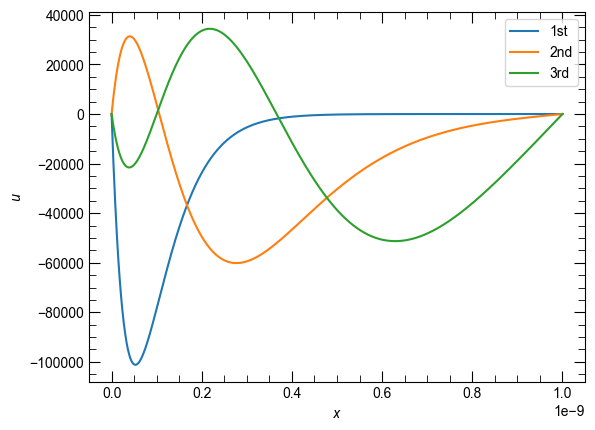

In [12]:
val, vec = solve_schrodinger(xs, v)
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")

In [13]:
def solve_poisson(xs, vec_0):
    femeig = Mel1dSparse(xs)
    F = femeig.get_F(e * vec_0[:, 0] ** 2 / (4 * np.pi * x_centers**2) / epsilon_0)
    F = x_centers**2 * F[:-1]
    K_poisson = femeig.get_K(x_centers**2)
    K_poisson_csr = csr_matrix(K_poisson)
    K_poisson_dirichlet = K_poisson_csr[:-1, :-1]
    F[-1] -= K_poisson_csr[-2, -1] * (-e / (4 * np.pi * epsilon_0 * x_centers[-1]))
    x, info = cg(K_poisson_dirichlet, F)
    return x

(-10.0, 0.0)

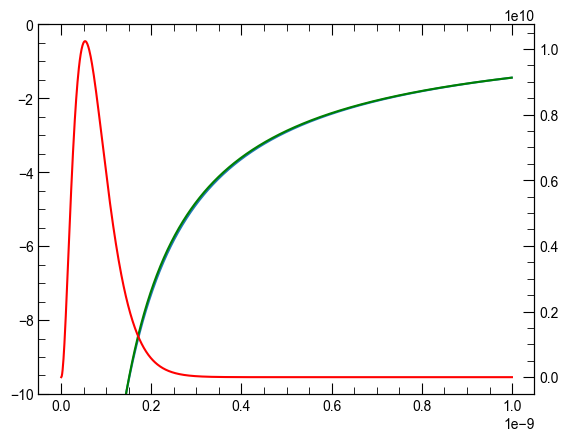

In [14]:
x = solve_poisson(xs, vec_0)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(xs[:-1], x)
ax2.plot(x_centers, vec_0[:, 0] ** 2, color="red")
ax.plot(xs[:-1], -e / (4 * np.pi * epsilon_0 * xs[:-1]), color="green")
ax.set_ylim(-1e1, 0)

In [15]:
v = -2 * C1 / x_centers - e * x
val, vec = solve_schrodinger(xs, v)
print(val / eV)
vec_0 = np.insert(vec, 0, 0, axis=0)

[-32.13835646  -4.55816795  -1.72810577]


(-1e-17, 1e-17)

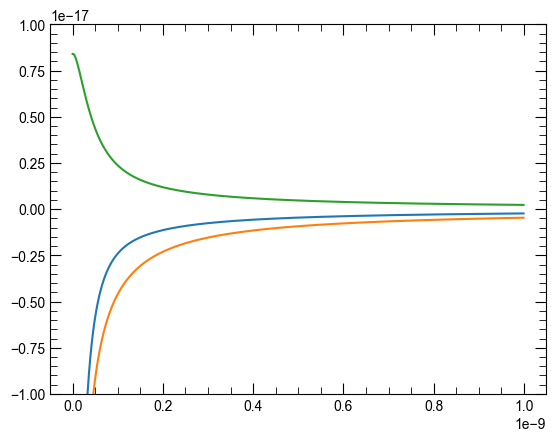

In [16]:
x = solve_poisson(xs, vec_0)
fig, ax = plt.subplots()
ax.plot(xs[:-1], v)
ax.plot(xs[:-1], -2 * C1 / x_centers)
ax.plot(xs[:-1], -e * x)
ax.set_ylim(-1e-17, 1e-17)

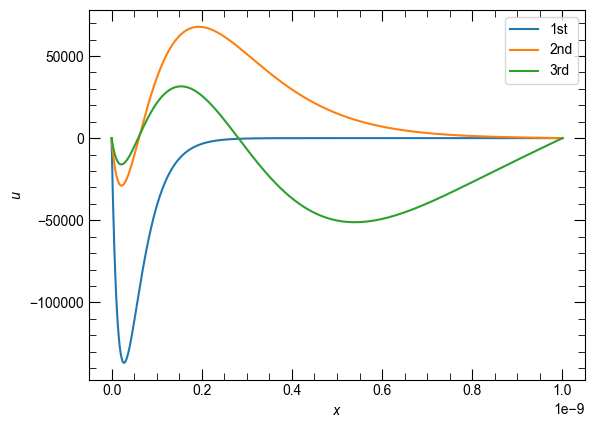

In [17]:
val, vec = solve_schrodinger(xs, v)
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")

In [18]:
vec_a = vec_0
vec_b = vec_0
x_a = x
x_b = x
for i in range(10):
    v_a = -2 * C1 / x_centers - e * x_b
    val_a, vec_a = solve_schrodinger(xs, v_a)
    vec_0_a = np.insert(vec_a, 0, 0, axis=0)
    x_a = solve_poisson(xs, vec_0_a)
    v_b = -2 * C1 / x_centers - e * x_a
    val_b, vec_b = solve_schrodinger(xs, v_b)
    vec_0_b = np.insert(vec_b, 0, 0, axis=0)
    x_b = solve_poisson(xs, vec_0_b)
    print(val_a / eV)
    print(val_b / eV)

[-22.25874509  -4.00079536  -1.54001403]
[-24.78887587  -4.14984111  -1.59325859]
[-23.92436101  -4.10048224  -1.57586668]
[-24.19494321  -4.11606098  -1.58138107]
[-24.10779977  -4.11105944  -1.57961317]
[-24.13561107  -4.11265356  -1.58017674]
[-24.12670644  -4.11214277  -1.57999625]
[-24.12955474  -4.11230843  -1.58005496]
[-24.12864511  -4.11225476  -1.58003575]
[-24.12893474  -4.11227011  -1.58004119]
[-24.12884137  -4.11226715  -1.58004025]
[-24.12887341  -4.11227101  -1.58004172]
[-24.12886429  -4.11226665  -1.58004011]
[-24.12886448  -4.11226957  -1.58004121]
[-24.12886674  -4.11226938  -1.58004122]
[-24.12886579  -4.1122697   -1.58004125]
[-24.12886644  -4.11227017  -1.58004139]
[-24.12886683  -4.11227233  -1.58004244]
[-24.12886796  -4.11226864  -1.58004082]
[-24.12886501  -4.112272    -1.58004211]


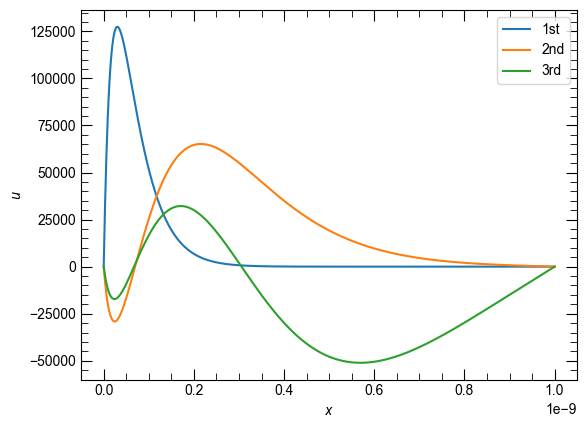

In [19]:
vec = vec_a
vec_0 = np.insert(vec, 0, 0, axis=0)
vec_0_m1 = np.insert(vec_0, vec_0.shape[0], 0, axis=0)
fig, ax = plt.subplots()
ax.plot(xs, vec_0_m1[:, 0], label="1st")
ax.plot(xs, vec_0_m1[:, 1], label="2nd")
ax.plot(xs, vec_0_m1[:, 2], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")

In [24]:
vec_a[:, 0].shape

(998,)

In [28]:
xs[1:-1].shape

(998,)

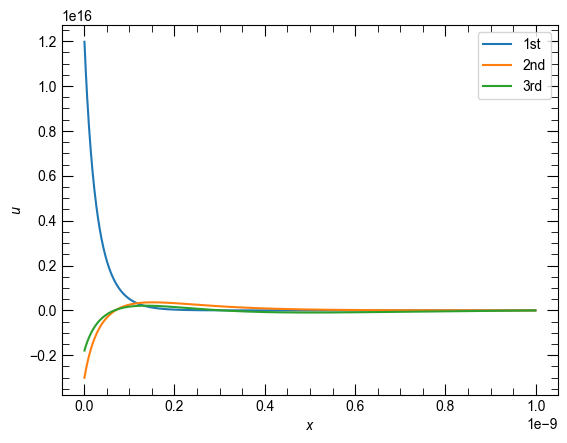

In [29]:
fig, ax = plt.subplots()
ax.plot(xs[1:-1], vec_a[:, 0] / xs[1:-1], label="1st")
ax.plot(xs[1:-1], vec_a[:, 1] / xs[1:-1], label="2nd")
ax.plot(xs[1:-1], vec_a[:, 2] / xs[1:-1], label="3rd")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
fig.savefig("eigenfunction.pdf")